<center>
    <h3> Real-Time Time Dependent Orbital Free Density Functional Theory with DFTpy</h3>
    <h3>Tutorial</h3>
</center>
<table>
  <tr>
      <td><p><h4>Rutgers University-Newark</h4></p><p>Dr Xuecheng Shao</p><p>Dr Kaili Jiang (Microsoft)</p><p>Dr. Bhaskar Rana</p><p>Jessica Martinez</p><p>Valeria Rios </p><p>Alina Umerbekova</p></td>
          <td><img src="../../2024/figures/logos/logo.jpg" width=800 /></td>
  </tr>
</table>

ASESMA 2025

## Goal: COmpute optical spectra with DFTpy
#### 1) Obtain a good initial density with LMGP (OESCF)
#### 2) Compute the Optical Spectra (plasmons) of a Mg<sub>8</sub> from a good initial density  
#### Challenge: Obtain the spectrum of your own cluster

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
from dftpy.grid import DirectGrid
from dftpy.field import DirectField
from dftpy.functional import Functional, TotalFunctional
from dftpy.optimization import Optimization
from dftpy.td.propagator import Propagator
from dftpy.td.hamiltonian import Hamiltonian
from dftpy.utils.utils import calc_rho, calc_j
from dftpy.td.utils import initial_kick
from dftpy.ions import Ions
from dftpy.formats import io
from dftpy.constants import Units
from dftpy.td.utils import calc_spectra_mu

In [1]:
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
!wget https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF

--2025-05-23 11:33:19--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg8.vasp
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839 [text/plain]
Saving to: ‘Mg8.vasp.2’

100%[======================================>] 839         --.-K/s   in 0s      

2025-05-23 11:33:19 (273 MB/s) - ‘Mg8.vasp.2’ saved [839/839]

--2025-05-23 11:33:19--  https://gitlab.com/pavanello-research-group/dftpy/-/raw/master/examples/DATA/Mg_OEPP_PZ.UPF
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98081 (96K) [text/plain]
Saving to: ‘Mg_OEPP_PZ.UPF.1’

100%[======================================>] 98,081      --.-K/s   in 0.002s  

2025-05-23 11:33:19 (52

### Read the vasp file with DFTpy

In [12]:
ions = io.read('Mg8.vasp', format='vasp', names=['Mg'])

### Create the PP list and the Grid
DirectGrid is a class object that represents a grid (Cell plus discretization)

In [13]:
PP_list = ['./Mg_OEPP_PZ.UPF']
grid = DirectGrid(ions.cell, spacing = 1.1)

In [14]:
grid.nr

array([36, 36, 32], dtype=int32)

### Define the functionals for OF-DFT

In [15]:
xc = Functional(type='XC',name='LDA')
hartree = Functional(type='HARTREE')
pseudo = Functional(type='PSEUDO', grid=grid, ions=ions, PP_list=PP_list)

setting key: Mg -> ./Mg_OEPP_PZ.UPF


### Represented a field on a grid
Write on the grid the initial electronic density

In [16]:
rho_ini = DirectField(grid=grid)
rho_ini[:] = ions.get_ncharges()/ions.cell.volume

### Write the optimization options and build the class that handles the electron density optimization

In [18]:
optimization_options = {'econv' : 1e-11,'maxiter' : 100}

#### Run the optimization of the electronic density with TF0.2vW

In [19]:
ke = Functional(type='KEDF',name='TFvw', y=0.2)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)
opt = Optimization(EnergyEvaluator=totalfunctional, optimization_options = optimization_options,
        optimization_method = 'TN')
rho = opt.optimize_rho(guess_rho=rho_ini)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.951916882520E+00      8.951917E+00    2.343046E+00    1       1       6.814027E-02    
!WARN: Change to steepest decent
1       -5.391241844465E+00     -1.434316E+01   1.315224E+00    1       3       2.070432E-01    
2       -6.787012622638E+00     -1.395771E+00   1.519794E-01    2       2       3.315430E-01    
3       -7.028248165620E+00     -2.412355E-01   1.639105E-02    5       3       5.766327E-01    
4       -7.058369899401E+00     -3.012173E-02   1.701950E-03    5       2       7.870882E-01    
5       -7.059908538050E+00     -1.538639E-03   1.781698E-04    3       2       9.444754E-01    
6       -7.060408858840E+00     -5.003208E-04   1.085883E-05    6       3       1.227783E+00    
7       -7.060419731612E+00     -1.087277E-05   1.330579E-06    4       3       1.437867E+00    
8       -7.060420451079E+00     -7.194673E-07   6.550505E-07    3       3       1.622600E+00  

In [20]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)

In [21]:
from dftpy.mixer.pulay import PulayMixer
pulay=PulayMixer(mp=None)

In [25]:
from dftpy.optimization import OESCF

In [26]:
vw = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vw, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

kedf_emb = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [28]:
rho0 = opt.optimize_rho(guess_rho=rho, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -7.204193641031E+00     -7.204194E+00   9.995992E-01    1       1       2.990341E-02    
1       -7.529011922738E+00     -3.248183E-01   2.821872E-01    1       2       1.088724E-01    
2       -7.613763382982E+00     -8.475146E-02   1.327598E-01    1       2       1.588972E-01    
3       -7.668002809349E+00     -5.423943E-02   8.002918E-02    1       2       2.350304E-01    
4       -7.685169186495E+00     -1.716638E-02   4.265207E-02    1       2       2.924607E-01    
5       -7.693641678342E+00     -8.472492E-03   1.840613E-02    1       3       3.852708E-01    
6       -7.697651030751E+00     -4.009352E-03   1.091548E-02    1       3       4.814196E-01    
7       -7.700602902087E+00     -2.951871E-03   8.468518E-03    1       2       5.245492E-01    
8       -7.701732211061E+00     -1.129309E-03   2.725775E-03    1       2       5.996442E-01    
9       -7.702427754555E+00   

# Time dependent part
### Remove the von Wäzecker KEDF
Change the KE functional in the total functional to Pauli functional, the laplacian is handled by the hamiltonian
$$
v_p(\mathbf{r},t) = v_{Ts}(\mathbf{r},t) - v_{vW}(\mathbf{r},t)
$$

##### Initialize the Time propagation from $n_{LMGP}(\mathbf{r})$
$$H(t) = H(t_0) + [\tilde{H}(t)-\tilde{H}(t_0)]$$
$$v_B(\mathbf{r},t) = v_B(\mathbf{r},t_0) + [\tilde{v}_B(\mathbf{r},t)-\tilde{v}_B(\mathbf{r},t_0)]$$
$$
[-\frac{1}{2}\nabla ^2 + v_B(\mathbf{r},t_0)]\phi_B(\mathbf{r},t_0) = \mu \phi_B(\mathbf{r},t_0) \rightarrow v_B(\mathbf{r},t_0) = \underbrace{\frac{1}{2}\frac{\nabla ^2 \phi_B(\mathbf{r},t_0)}{\phi_B(\mathbf{r},t_0)}}_{-v_{vW}[n(\mathbf{r},t_0)]} + \mu 
$$
$$
v_B(\mathbf{r},t) = -v_{vW}(\mathbf{r},t_0) + [\tilde{v}_s(\mathbf{r},t)+\tilde{v}_p(\mathbf{r},t)-\tilde{v}_s(\mathbf{r},t_0)-\tilde{v}_p(\mathbf{r},t_0)]
$$
$$
\therefore v_B(\mathbf{r},t) = -v_{vW}[n(\mathbf{r},t_0)] + [\tilde{v}_s(\mathbf{r},t)+\tilde{v}_p(\mathbf{r},t)-\tilde{v}_s[n(\mathbf{r},t_0)]-\tilde{v}_p[n(\mathbf{r},t_0)]]
$$

In [100]:
ke = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
totalfunctional = TotalFunctional(KEDF=ke, XC=xc, HARTREE=hartree, PSEUDO=pseudo)

ke.options.update({'y':0})
v_vw = vw(rho0).potential 
v_s = pseudo(rho0).potential + hartree(rho0).potential + xc(rho0).potential
v_p = ke(rho0).potential
v_ext = -(v_vw + v_s + v_p)

In [101]:
from dftpy.functional.external_potential import ExternalPotential

In [103]:
ext = ExternalPotential(v=v_ext)
totalfunctional.UpdateFunctional(newFuncDict={'EXT': ext})

### Verify Ground state
BUild the hamiltonian and diagonalize it to verify that the propagation starts with the correct initial density 

In [104]:
potential = totalfunctional(rho0).potential
H = Hamiltonian(v=potential)
eigval, psi_list = H.diagonalize(numeig=1)

In [105]:
psi_lmgp = np.sqrt(rho0)

In [106]:
N = (psi_lmgp*psi_lmgp).integral()

In [107]:
rho_h = N * (psi_list[0]*psi_list[0])

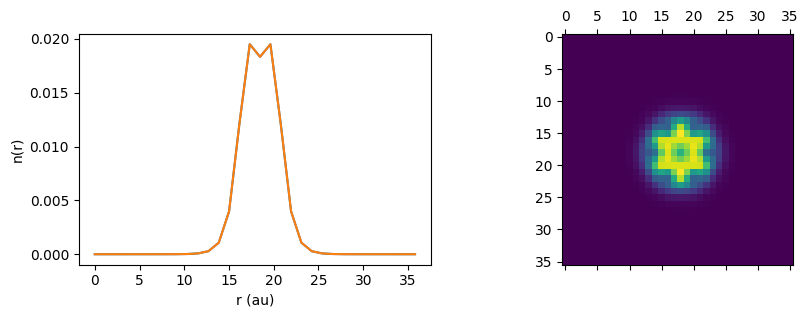

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_h[16,16,:].ravel()))
axs[0].plot(r, rho_h[15,15,:].ravel())
axs[0].plot(r, rho0[15,15,:].ravel())
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_h[:,:,15])

## Time propagation

In [77]:
from qepy.qepy_modules import constants
au_sec = constants.get_au_sec()
as2au = 1.0E-18 / au_sec
bohr = constants.get_angstrom_au()
k = 0.01*bohr
interval = 1.0 * as2au
ha = constants.get_autoev()

In [78]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively

## Run with Crank Nicholson propagator

In [79]:
from dftpy.optimize import Dynamics


class Runner(Dynamics):

    def __init__(self, rho0, totalfunctional, k, direction, interval, max_steps):
        super(Runner, self).__init__()
        self.max_steps = max_steps
        self.totalfunctional = totalfunctional
        self.rho0 = rho0
        self.rho = rho0
        self.psi = initial_kick(k, direction, np.sqrt(self.rho0))
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho0, current=self.j, calcType=['V']).potential
        hamiltonian = Hamiltonian(v=potential)
        self.prop = Propagator(hamiltonian, interval, name='crank-nicholson')
        self.dipole = []
        self.attach(self.calc_dipole) # this attaches the calc_dipole function to the observers list which runs after each time step.

    def step(self):
        self.psi, info = self.prop(self.psi)
        self.rho = calc_rho(self.psi)
        self.j = calc_j(self.psi)
        potential = self.totalfunctional(self.rho, current=self.j, calcType=['V']).potential
        self.prop.hamiltonian.v = potential
        print("\r", end="")
        print(f"Progress: [{self.nsteps+1}/{self.max_steps}]", "|" * (self.nsteps*50 // self.max_steps), end="", flush=True)

    def calc_dipole(self):
        delta_rho = self.rho - self.rho0
        delta_mu = (delta_rho * delta_rho.grid.r).integral()
        self.dipole.append(delta_mu)

In [86]:
max_steps = 1000
runner = Runner(rho0, totalfunctional, k, direction, interval, max_steps)
runner()

Progress: [1000/1000] |||||||||||||||||||||||||||||||||||||||||||||||||

False

In [87]:
t = np.linspace(0, interval * max_steps, max_steps + 1)
mu = np.asarray(runner.dipole)

## Plot the dipole moment

Text(0, 0.5, 'Dipole Moment (au)')

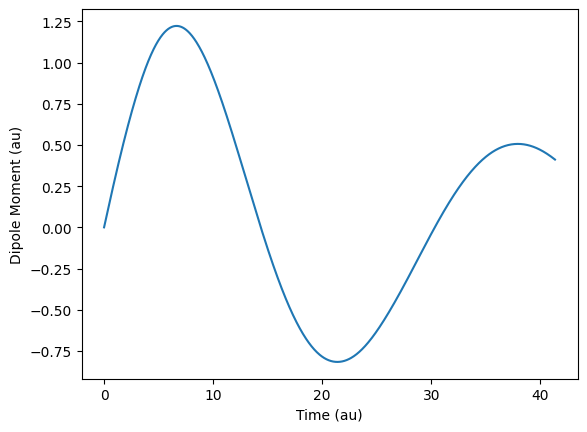

In [88]:
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

## Plot the optical spectra

(0.0, 20.0)

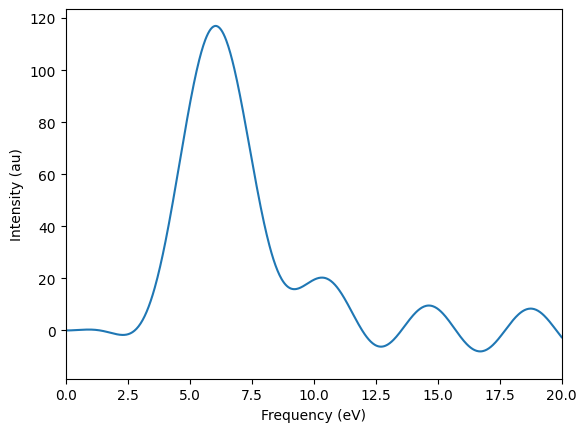

In [89]:
sigma = 0.2*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, sigma=sigma, kick=k)
plt.plot(omega*Units.Ha, spectra, '-')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 20)

## Challenge 

Calculate the optical spectra of your own cluster

### Build a cluster with ASE


In [93]:
from ase.cluster.cubic import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [2, 2, 2]
lc = 3.61000
atoms = FaceCenteredCubic('Cu', surfaces, layers, latticeconstant=lc)
atoms.set_cell([10,10,10])
atoms.wrap()
atoms.center(vacuum=10.0)

In [94]:
atoms.get_global_number_of_atoms()

19

In [95]:
import py3Dmol
from ase.build import bulk
from ase.io import write
from ase.constraints import FixBondLength
write('cluster.xyz',atoms)
v = py3Dmol.view(data=open('./cluster.xyz','r').read(), style='sphere',linked=False)

v.addUnitCell()
v.zoomTo()
v.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.